In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import (
    AveragePooling2D,
    Input,
    Flatten,
    GlobalAveragePooling2D,
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import numpy as np

/usr/local/lib/python3.6/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


# TL;DR - to make them identical..

- Do manual stft computation and matrix dot (or tensor dot)
- `pad_end=False` for `tf.stft` and `center=False` for `librosa.stft`.
- `htk=False` and `norm=None` for `librosa.filters.mel`

In [2]:
sess = tf.InteractiveSession()

In [3]:
sr = 16000
filename = librosa.util.example_audio_file()
x, _ = librosa.load(filename, sr=sr)
x = x[:5 * sr]

In [4]:
EPS = 1e-6
NUM_FFT = 512
HOP_LENGTH = 160
NUM_MEL = 128
NUM_FREQS = NUM_FFT // 2 + 1
SAMPLE_RATE = sr
F_MIN = 0
F_MAX = SAMPLE_RATE / 2

# compare the windows

In [5]:
tf_hann = sess.run(tf.signal.hann_window(16))
lb_hann = librosa.filters.get_window('hann', 16, fftbins=True)
print('hann window difference: ', tf_hann - lb_hann)

hann window difference:  [ 0.00000000e+00  1.41537452e-08  6.05080852e-09 -1.17894858e-08
  0.00000000e+00  4.15918081e-08  2.37515139e-08  4.54508996e-08
  0.00000000e+00 -1.41537452e-08 -3.58531309e-08 -1.37222126e-07
  0.00000000e+00 -7.13941304e-08 -1.13158481e-07 -1.56485773e-08]


# stft

In [6]:
stfts = tf.abs(tf.signal.stft(
            x,
            frame_length=NUM_FFT,
            frame_step=HOP_LENGTH,
            fft_length=NUM_FFT,
            pad_end=False,
            window_fn=tf.signal.hann_window,
            # librosa test compatibility
        ))

tf_stft = (sess.run(stfts))
print(tf_stft.shape)
lb_stft = librosa_stft = np.abs(librosa.stft(y=x, n_fft=NUM_FFT, hop_length=HOP_LENGTH, 
                                   center=False, 
#                                    pad_mode='zeros',  # it's the same because when center=False it doesn't pad the signal.
                                   win_length=NUM_FFT))
print(lb_stft.shape)

print('STFT maximum abs diff: ', np.max(tf_stft - librosa_stft.transpose()))

(497, 257)
(257, 497)
STFT maximum abs diff:  1.9073486e-06


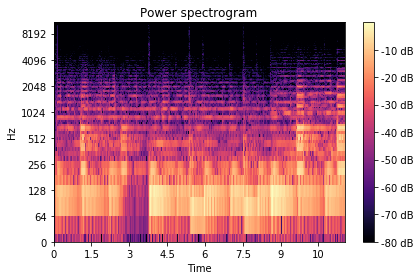

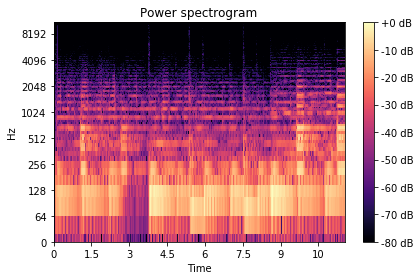

In [7]:
import matplotlib.pyplot as plt
import librosa.display
librosa.display.specshow(librosa.amplitude_to_db(tf_stft.T,
                                                ref=np.max),
                         y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()
librosa.display.specshow(librosa.amplitude_to_db(lb_stft,
                                                ref=np.max),
                         y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


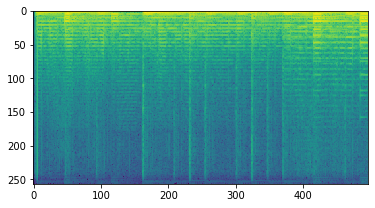

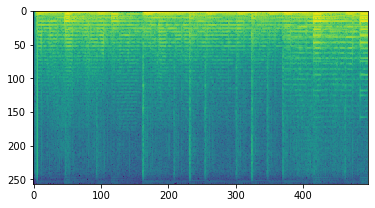

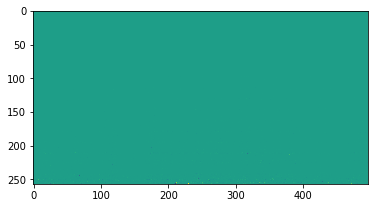

In [8]:
plt.imshow(np.log10(tf_stft ** 2).T)
plt.figure()
plt.imshow(np.log10(librosa_stft ** 2))
plt.figure()
plt.imshow(np.log10(librosa_stft ** 2) - np.log10((tf_stft** 2).T))

# lin to mel matrix

In [9]:
tf_l2m = sess.run(tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=NUM_MEL,
            num_spectrogram_bins=257,
            sample_rate=sr,
            lower_edge_hertz=0,
            upper_edge_hertz=sr//2,
        ))
print(tf_l2m.shape)
lb_l2m = librosa.filters.mel(sr=sr, 
                             n_fft=NUM_FFT, 
                             n_mels=NUM_MEL, 
                             fmin=0, 
                             fmax=sr//2, 
                             htk=True, 
                             norm=None)
print(lb_l2m.shape)
np.max(lb_l2m.T - tf_l2m)

(257, 128)
(128, 257)


0.002444774

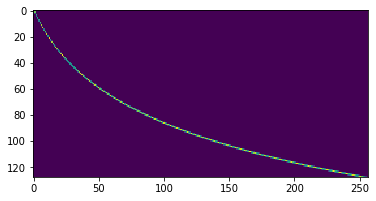

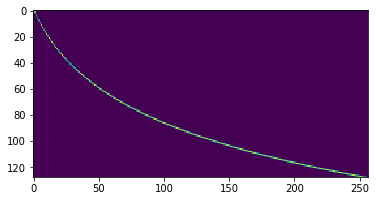

In [10]:
plt.figure()
plt.imshow(tf_l2m.T)

plt.figure()
plt.imshow(lb_l2m)


## be careful!

In librosa, `htk=False` and `norm=1` are default, and with these values they're not indentical.

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:196: FutureWarning: norm=1 behavior will change in librosa 0.8.0. To maintain forward compatibility, use norm='slaney' instead.
  FutureWarning)


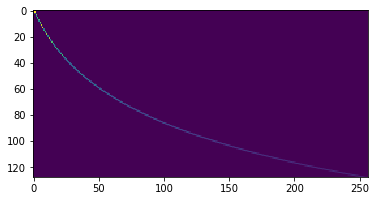

In [11]:
lib_l2m_diff = librosa.filters.mel(sr=sr, n_fft=NUM_FFT, n_mels=NUM_MEL, fmin=0, fmax=sr//2, htk=True, norm=1)
plt.imshow(lib_l2m_diff)

# matrix dot of them

(497, 128)
(497, 128)
melgram differences: 0.0035620928


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app


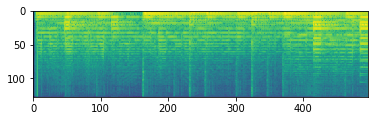

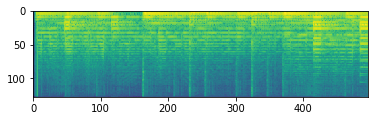

In [12]:
#tf_melgramm = np.log10(np.dot(tf_stft,tf_l2m))
def log10(x):
    numerator = tf.log(x)
    denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator
tf_melgramm = sess.run(log10(tf.tensordot(tf_stft,tf_l2m,1)))
print(tf_melgramm.shape)
lb_melgramm = np.log10(np.dot(librosa_stft.T, lb_l2m.T))
print(lb_melgramm.shape)
plt.figure()
plt.imshow(tf_melgramm.T)
plt.figure()
plt.imshow(lb_melgramm.T)

print('melgram differences:', np.nanmax(np.abs(tf_melgramm - lb_melgramm)))

In [13]:
print(tf_stft.shape, tf_l2m.shape)

(497, 257) (257, 128)


### FYI, when different linear-to-mel matrix are used..

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


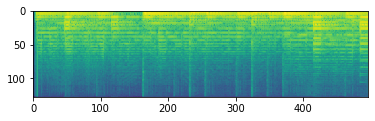

In [14]:
plt.figure()
plt.imshow(np.log10(np.dot(tf_stft, lib_l2m_diff.T)).T)


# But librosa.melspectrogram is..

little trickier. I gave up here. I'll show you this, have no idea why they're different.

In [15]:
power = 1
librosa_melgram = (librosa.feature.melspectrogram(S=librosa_stft, 
                                                  sr=SAMPLE_RATE, 
                                                n_fft=NUM_FFT, 
                                                n_mels=NUM_MEL,
                                                fmin=0,
                                                fmax=sr//2,
                                                htk=True,
                                                norm=None,
                                                 power=1))
librosa_melgram.shape

(128, 497)

In [16]:
tf_melgram = np.dot(tf_stft,tf_l2m)
tf_melgram.shape

(497, 128)

In [17]:
np.max(np.abs(librosa_melgram.T - tf_melgram))

0.065662384

BUT WHY is it not `0.0695914742891155`??

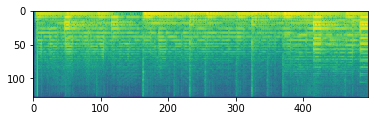

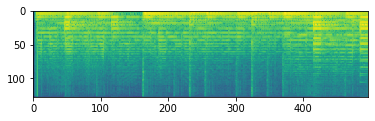

In [18]:
plt.imshow(np.log10(librosa_melgram + EPS))
plt.figure()
plt.imshow(np.log10(tf_melgram.T + EPS))
